In [ ]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style("darkgrid")
import lightgbm as lgb

In [ ]:
# import grocery data
data_demog = pd.read_csv('hh_demographic.csv')
data_trans = pd.read_csv('transaction_data.csv') # has 2 million rows
data_prods = pd.read_csv('product.csv')

In [ ]:
# demographic data
data_demog.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [ ]:
# transactional data
data_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
# product data
data_prods.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [ ]:
# strawberries have any 4 different sizes, 9 different manufacturers, 2 deparments and 48 different IDs
data_prods[data_prods.SUB_COMMODITY_DESC == 'STRAWBERRIES'].nunique()

PRODUCT_ID              48
MANUFACTURER             9
DEPARTMENT               2
BRAND                    1
COMMODITY_DESC           2
SUB_COMMODITY_DESC       1
CURR_SIZE_OF_PRODUCT     4
dtype: int64

In [ ]:
straw_id = data_prods.loc[data_prods.SUB_COMMODITY_DESC == 'STRAWBERRIES', 'PRODUCT_ID'].unique()

data_trans.loc[data_trans.PRODUCT_ID.isin(straw_id), 'SALES_VALUE'].value_counts().head(10)

2.99    2694
2.50    1037
2.00     877
5.00     469
4.00     357
3.49     294
5.98     275
1.50     263
1.67     230
3.99     222
Name: SALES_VALUE, dtype: int64

In [ ]:
#data.head(1000).sort_values('DAY')['SALES_VALUE'].rolling(3, min_periods=1).apply(lambda x: mode(x)[0])
def days(day, window):
    days = []
    for i in range(window + 1):
        if day > 0:
            day = day - i
            days.append(day)
    return days

def rolling_mode(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(mode(data_cut.SALES_VALUE)[0][0])
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mode']
    return result

def rolling_mean(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(np.mean(data_cut.SALES_VALUE))
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mean']
    return result

In [ ]:
# merge all three datasets
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

In [ ]:
# get data for strawberry purchases
data_straw = data.copy()
data_straw = data_straw[data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES']
mode_rolling = rolling_mode(data_straw, window=3)
mean_rolling = rolling_mean(data_straw, window=3)

In [ ]:
# try different imputations
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw.merge(mean_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw['price_mean'] = data_straw.groupby('DAY')['SALES_VALUE'].transform(lambda x: x.mean())

In [ ]:
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

# restrict dataset to customers who purchased strawberries at least once
b = data.groupby('household_key')['SUB_COMMODITY_DESC'].apply(lambda x: (x == 'STRAWBERRIES').any())
data = data[data.household_key.isin(b[b].index)]
print("Number of shopping trips after removing non-strawberry purchasing customers:", data.BASKET_ID.nunique())

data['BASKET_ID'] = data['BASKET_ID'].astype(str)
data['MANUFACTURER'] = data['MANUFACTURER'].astype(str)

# imputing missing values
data_straw = data.copy()
data_straw = data_straw[(data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES')]
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw[~data_straw.BASKET_ID.duplicated()]
data_straw['purchased'] = 1

# baskets where strawberries were not purchased
data_non_straw = data.copy()
data_non_straw = data_non_straw[data_non_straw.SUB_COMMODITY_DESC != 'STRAWBERRIES']
data_non_straw = data_non_straw[~data_non_straw.BASKET_ID.duplicated()]
data_non_straw = data_non_straw.merge(data_straw[['DAY', 'rolling_mode']], left_on='DAY', right_on='DAY')
data_non_straw['purchased'] = 0

data = pd.concat([data_straw, data_non_straw], axis=0)

# impute product categorical features using mode 
data.loc[data.purchased == 0, 'SALES_VALUE'] = data.loc[data.purchased == 0, 'rolling_mode']
data.loc[data.purchased == 0, 'MANUFACTURER'] = data_straw.loc[:, 'MANUFACTURER'].value_counts().index[0]
data.loc[data.purchased == 0, 'DEPARTMENT'] = data_straw.loc[:, 'DEPARTMENT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COMMODITY_DESC'] = data_straw.loc[:, 'COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'CURR_SIZE_OF_PRODUCT'] = data_straw.loc[:, 'CURR_SIZE_OF_PRODUCT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_DISC'] = data_straw.loc[:, 'COUPON_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_MATCH_DISC'] = data_straw.loc[:, 'COUPON_MATCH_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'SUB_COMMODITY_DESC'] = data_straw.loc[:, 'SUB_COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'BRAND'] = data_straw.loc[:, 'BRAND'].value_counts().index[0]

# drop id columns and rename SALES_VALUE to price
data = data.drop_duplicates()
data.drop(['PRODUCT_ID', 'household_key', 'BASKET_ID'], axis=1, inplace=True)
data.rename(columns={'SALES_VALUE':'price'}, inplace=True)
data.CURR_SIZE_OF_PRODUCT = data.CURR_SIZE_OF_PRODUCT.replace({'16 OZ', '1 LB'})
data = data[data.CURR_SIZE_OF_PRODUCT == '16 OZ']

# balance classed
# data = pd.concat([
#     data[data.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     data[data.purchased == 1]
# ], axis=0)

#data.INCOME_DESC = data.INCOME_DESC.apply(lambda x: int(''.join([y for y in x.split('-')[0] if y.isdigit()])))

print(len(data))
data.head()

Number of shopping trips after removing non-strawberry purchasing customers: 108662
109842


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,DAY,price,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,rolling_mode,purchased
0,1646,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,134.0,2.50,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
1,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,125.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
2,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,130.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.00,1
3,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,415.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1
4,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,428.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1


#
Most of the imputed prices are between 1 and 4 dollars, with a few exceptions ranging from 5 to 8 dollars. 

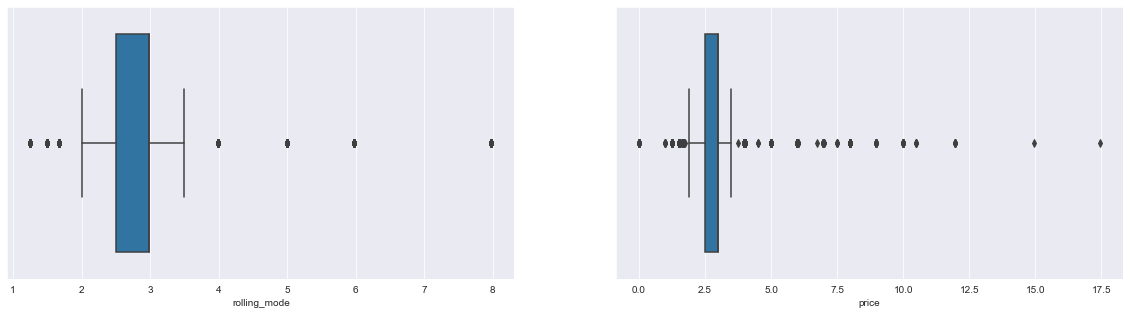

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x=data.rolling_mode, ax=ax[0])
sns.boxplot(x=data.price, ax=ax[1])

plt.show()

#
Taking the mean price of each day is still to noisy. This can be smoothed by taking the mean or mode of a rolling 3 day period.

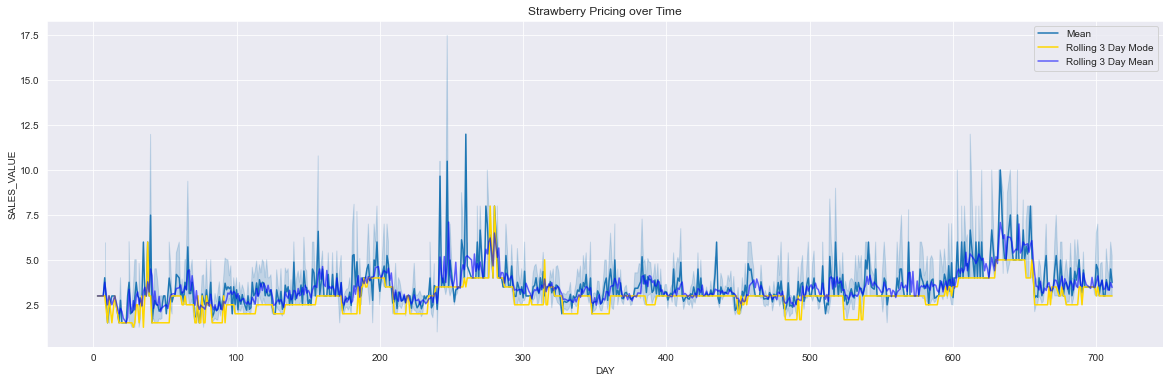

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))

sns.lineplot(data=data_straw, x="DAY", y="SALES_VALUE")#, hue="CURR_SIZE_OF_PRODUCT", ax=ax)
sns.lineplot(data=mode_rolling, x="DAY", y="rolling_mode", ax=ax, color='gold')
sns.lineplot(data=mean_rolling, x="DAY", y="rolling_mean", ax=ax, alpha=0.6, color='blue')

plt.legend(['Mean', 'Rolling 3 Day Mode', 'Rolling 3 Day Mean'])

plt.title('Strawberry Pricing over Time')
plt.show()

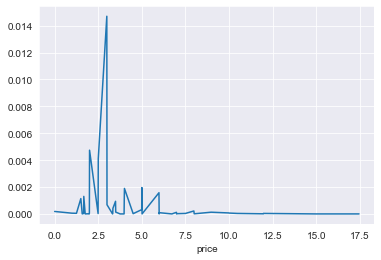

In [ ]:
(data.groupby('price')['purchased'].sum()/len(data)).plot()
plt.show()

<AxesSubplot:xlabel='price', ylabel='purchased'>

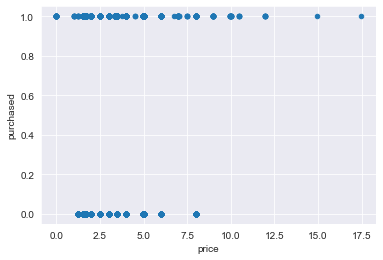

In [ ]:
data.plot(x='price', y='purchased', kind='scatter')

#
Use SMOTE to balance training data and lightBGM to model demand as a function of price. 

In [ ]:
X = data.copy()
X = X.drop(['rolling_mode', 'DAY'], axis=1)

# encode categorical features as integers
from sklearn import preprocessing
categorical_feature = []
for f in X.columns:
    if X[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values))
        X[f] = lbl.transform(list(X[f].values))
        categorical_feature.append(f)

# drop features with low variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X = selector.fit_transform(X)

# wrap in dataframe
X = pd.DataFrame(X)
X.columns = data.drop(['rolling_mode', 'DAY'], axis=1).columns[selector.get_support()]

X_orig = X.copy()

# downsample balance
# X = pd.concat([
#     X[X.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     X[X.purchased == 1]
# ], axis=0)

y = X['purchased']
X = X.drop('purchased', axis=1)

X.head()

,MANUFACTURER,DEPARTMENT,COMMODITY_DESC,price,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,0.0,1.0,0.0,2.50,3.0,2.0,0.0,4.0,3.0,0.0,3.0
1,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
2,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
3,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0
4,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0


In [ ]:
print(os.getcwd())
pd.concat([X, y], axis=1).to_csv('cleaned_strawberry_dataset.csv', index=False)

C:\Users\mlentini\OneDrive - Edmund Optics, Inc\Documents\Rowan\Thesis\Notebooks\student_prescription_tree


In [ ]:
num_round = 50 # number of boosting rounds as used in Biggs
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': '',
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'verbose': 1,
    'max_depth': -1
}

cats = np.where(X.columns.isin([x for x in X.columns if x not in ['price', 'INCOME_DESC']]))[0]
model = lgb.LGBMClassifier(n_estimators=num_round)#, categorical_feature=cats)#np.arange(len(X.columns)))#np.where(X.columns.isin(categorical_feature))[0])

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
#X_train, y_train = sm.fit_resample(X_train, y_train)

model.fit(X_train, y_train)

LGBMClassifier(n_estimators=50)

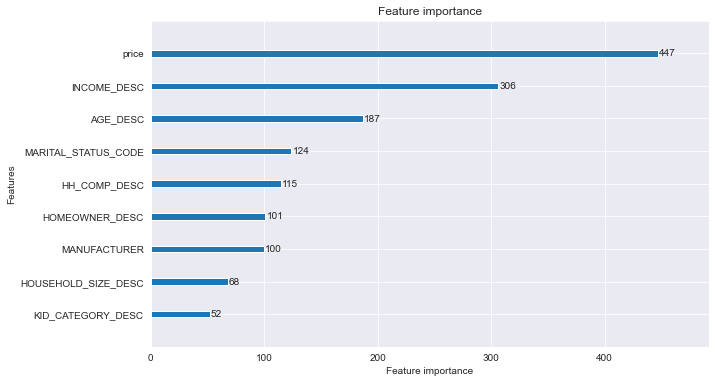

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax=ax)
plt.show()

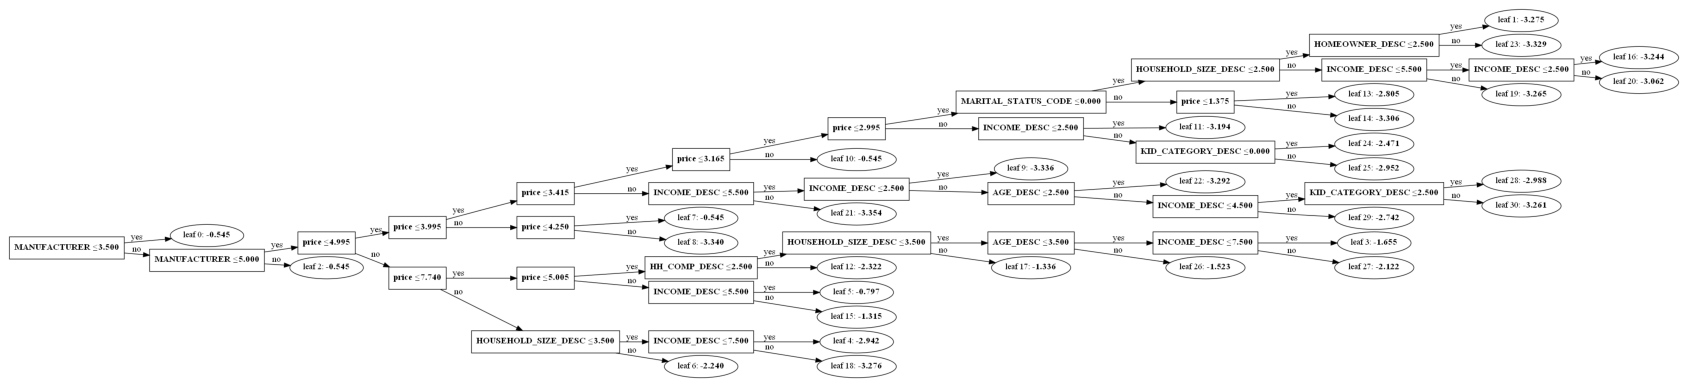

In [ ]:
gig, ax = plt.subplots(figsize=(30,8))
lgb.plot_tree(model, ax=ax)
plt.savefig('tree_plot.png')

plt.show()

#
Get counterfactual total expected revenue as a function of price

In [ ]:
def counterfactual(X_train, X_test):
    #Biggs et al, 2020 uses 10th and 90th percentile prices in 10% increments
    low_price = X_train.price.quantile(0.05)
    high_price = X_train.price.quantile(0.95)

    print('low price:', low_price)
    print('high price:', high_price)

    prices = np.linspace(low_price, high_price, 11)
    prices = np.linspace(1.99, 4.99, 7)
    revenue = []
    avg_purchase_prob = []
    for price in prices:
        counterfactual = X_test.copy()
        counterfactual.price = price
        purchase_prob = model.predict_proba(counterfactual)[:, 1]
        revenue.append(np.mean(price*purchase_prob))
        avg_purchase_prob.append(np.mean(purchase_prob))

    optimal_price = prices[np.where(revenue == np.max(revenue))][0]
    
    # join to original dataset before balanceing
#     X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=49)
#     X_train_[X_train_.index.isin(counterfactual.index)]
    
    return avg_purchase_prob, revenue, optimal_price, prices

low price: 1.67
high price: 3.99
Optimal price 2.99
Maximum Average Revenue: 0.107


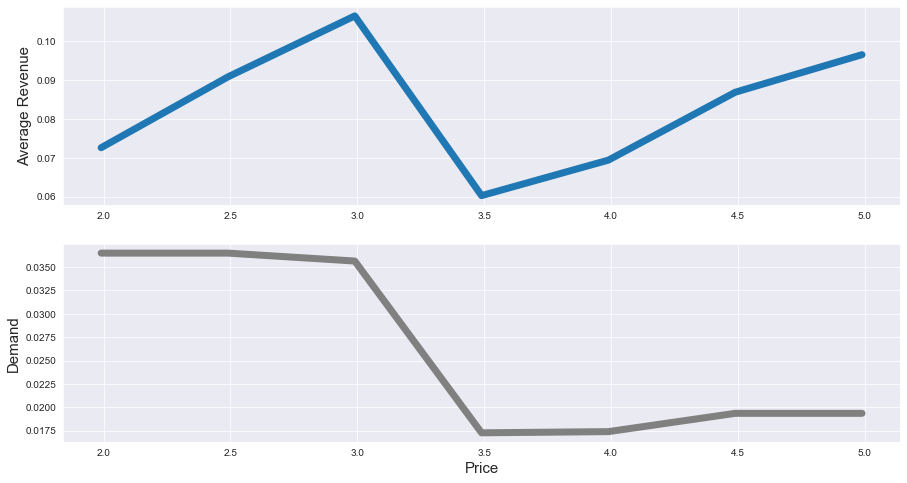

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=49)
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test)

#avg_purchase_prob = avg_purchase_prob[::-1]
#revenue = prices*avg_purchase_prob

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

In [ ]:
# model out-of-sample score
print('In-sample error:', model.score(X_test, y_test))
print('Out-of-sample score:', model.score(X_test, y_test))

In-sample error: 0.9740900566267912
Out-of-sample score: 0.9740900566267912


#
Out-of-sample AUC performed the same as Biggs et al., 2021. We both measured 0.79. Is is unclear whether Biggs et al., balanced the dataset, and if they did which technique was used.

In [ ]:
# out-of-sample scores
from sklearn.metrics import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
def evaluate(model, testing_set_x, testing_set_y):
    predictions = model.predict_proba(testing_set_x)
    
    accuracy  = accuracy_score(testing_set_y, predictions[:,1] >= 0.5)
    roc_auc   = roc_auc_score(testing_set_y, predictions[:,1])
    precision = precision_score(testing_set_y, predictions[:,1] >= 0.5)
    recall    = recall_score(testing_set_y, predictions[:,1] >= 0.5)
    pr_auc    = average_precision_score(testing_set_y, predictions[:,1])
    
    result = pd.DataFrame([[accuracy, precision, recall, roc_auc, pr_auc]], columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    return(result)

evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall,ROC_auc,PR_auc
0,0.973726,0.923304,0.310362,0.816968,0.453001


#
Experiment with how the demand curve changes for different income buckets

In [ ]:
np.concatenate([data.INCOME_DESC.unique().reshape(-1,1), X.INCOME_DESC.unique().astype(int).reshape(-1,1)], axis=1)

array([['100-124K', 0],
       ['75-99K', 10],
       ['Under 15K', 11],
       ['125-149K', 1],
       ['50-74K', 9],
       ['150-174K', 3],
       ['35-49K', 8],
       ['25-34K', 6],
       ['250K+', 7],
       ['200-249K', 5],
       ['15-24K', 2],
       ['175-199K', 4]], dtype=object)

low price: 1.67
high price: 3.99
low price: 1.67
high price: 3.99
Optimal price 2.99
Maximum Average Revenue: 0.184


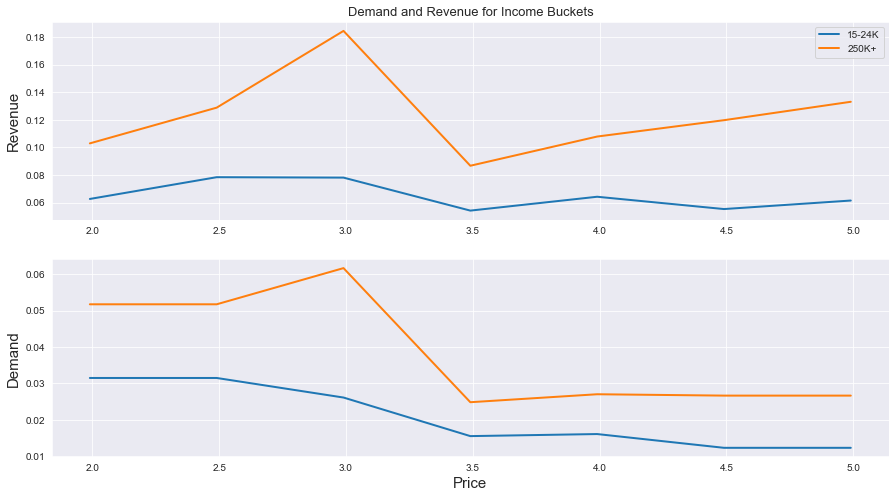

In [ ]:
# plot '15-24K'
income_bucket = 2
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test[X_test.INCOME_DESC == income_bucket])

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=2.0)
ax[0].set_ylabel('Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=2.0)#, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

# plot '250K+' for comparison
income_bucket = 7
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test[X_test.INCOME_DESC == income_bucket])
ax[0].plot(prices, revenue, linewidth=2.0)
ax[1].plot(prices, avg_purchase_prob, linewidth=2.0)#, color='grey')

# add legends
ax[0].set_title('Demand and Revenue for Income Buckets', fontsize=13)
ax[0].legend(['15-24K', '250K+'])

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

# 
Plot average revenue by tree depth from SPT

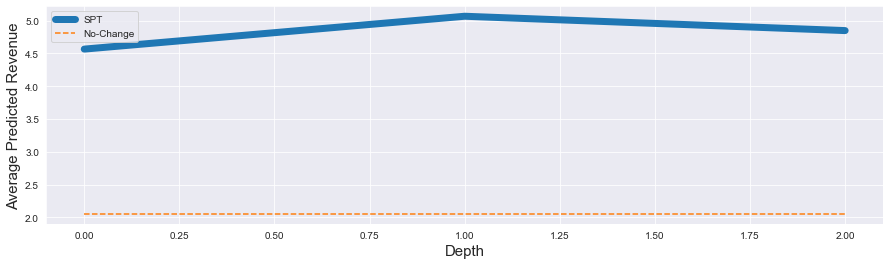

In [ ]:
results = [4.566902048915882, 5.067907694500349, 4.849184747578931]
f = 1
results = np.array(results)/f
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,3), results, linewidth=7.0)
ax.plot(np.arange(0,3), np.array(3*[2.0541071833989872])/f, '--')
ax.set_ylabel('Average Predicted Revenue', fontsize=15)
ax.set_xlabel('Depth', fontsize=15)

ax.legend(['SPT', 'No-Change'])
plt.show()

# Synthetic Datasets
#### Biggs et al. (2020)

Linear probit model:

$$Y^* = G(X) + h(X)P + \epsilon$$

Y = 1 if Y^* > = 0 and Y= 0 otherwise. We let $(X_0, X_1) \sim N(0,I_2), P \sim N(X_0+5,2), \epsilon \sim N(0,1)$ unless otherwise mentioned.

Dataset 1: linear probit model with no confounding: $G(X) = X_0, h(X) = -1, X \sim N(5, I_2)$ and $P \sim N(5,1)$

Dataset 5: linear probit model with observed confounding: $G(X) = X_0, h(X) = -1$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [3]:
# sample size
n = 10000

# Dataset 1
Dataset 1: linear probit model with no confounding

Optimal Average Revenue: 5.017379365871289


,X0,X1,price,optimal_price,Y
0,4.006652,6.110086,4.227856,5.006737,1
1,5.105566,6.247823,5.054975,3.786660,0
2,5.015390,5.241389,4.698853,6.116933,1
3,6.904667,1.129561,3.840246,6.540403,1
4,6.379418,5.724418,5.309573,5.733229,1


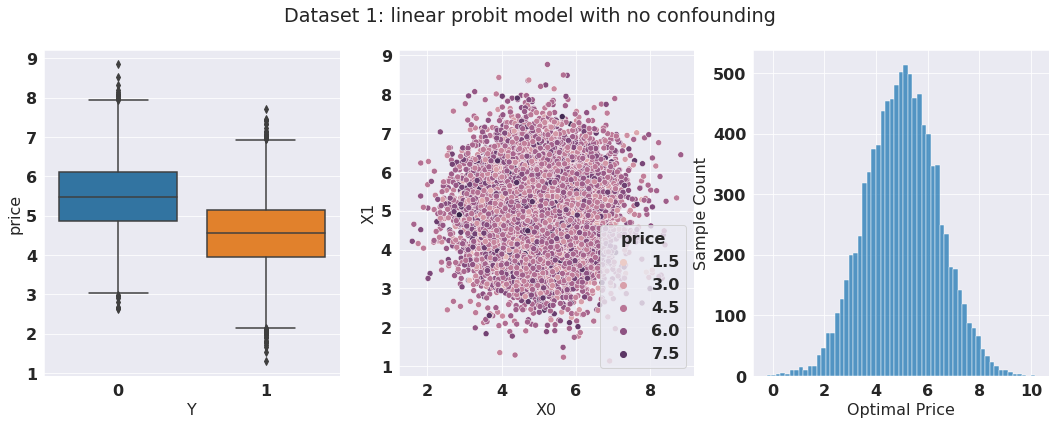

In [285]:
def model_1():
    # dataset 1: linear probit model with no confounding
    # np.random.seed(101)
    def generate_model_1():
        h = -1
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([5, 5], I2)
        X0 = X[0]
        X1 = X[1]
        P = np.random.normal(5, 1)
        epsilon = np.random.normal(0, 1)
            
        # compute optimal price
        g = X0
        optimal_price = -1*(g + epsilon)/h

        Y_star = g + h*P + epsilon 

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'optimal_price':[],
        'Y':[]
              }

    for i in range(n):
        X0, X1, P, Y_star, optimal_price = generate_model_1()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['optimal_price'].append(optimal_price)
        results['Y'].append(int(Y_star > 0))

    results = pd.DataFrame(results)

    # get header
    # results['dataset'] = 1
    return results
    
# visualize results
results = model_1()

# set model params
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

import matplotlib
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])
plt.suptitle("Dataset 1: linear probit model with no confounding")
 

ax[2].set_ylabel("Sample Count")
ax[2].set_xlabel("Optimal Price")
print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
results.head()

# Dataset 2
Dataset 2: higher dimension probit model with sparse linear interaction, where purchase probability is only dependent on the first 5 features.

Optimal Average Revenue: -2.112323893702129


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,price,optimal_price,Y,dataset
0,2.706850,0.628133,0.907969,0.503826,0.651118,-0.319318,-0.848077,0.605965,-2.018168,0.740122,...,-0.933237,0.955057,0.190794,1.978757,2.605967,0.683509,0.781056,-10.199805,1.0,2
1,0.184502,0.807706,0.072960,0.638787,0.329646,-0.497104,-0.754070,-0.943406,0.484752,-0.116773,...,0.196800,-1.136645,0.000366,1.025984,-0.156598,-0.031579,0.294054,2.471940,1.0,2
2,0.558769,1.024810,-0.925874,1.862864,-1.133817,0.610478,0.386030,2.084019,-0.376519,0.230336,...,-1.005187,-0.741790,0.187125,-0.732845,-1.382920,1.482495,2.585529,2.831410,1.0,2
3,-0.494095,-0.162535,0.485809,0.392489,0.221491,-0.855196,1.541990,0.666319,-0.538235,-0.568581,...,1.028293,-1.972605,-0.866885,0.720788,-1.223082,1.606780,-1.542657,61.159669,1.0,2
4,-0.804652,0.253548,0.649148,0.358941,-1.080471,0.902398,0.161781,0.833029,0.975720,-0.388239,...,0.677535,0.026105,-1.678284,0.333973,-0.532471,2.117727,0.486355,15.141173,1.0,2


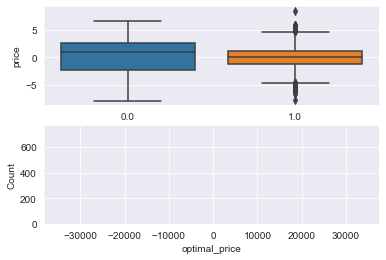

In [ ]:
def model_2():
    # dataset 2
    np.random.seed(101)
    def generate_model_2():
        g = 5
        X_prime = np.random.multivariate_normal([0]*20, np.identity(20))

        # draw beta 1 through 5
        beta_5 = np.random.multivariate_normal([0]*5, np.identity(5))
        beta_20 = [0]*15
        beta = np.concatenate([beta_5, beta_20])

        # take linear combo to get h(X)
        h = -1.5*(X_prime*beta).sum()

        # draw prices and noise
        P = np.random.normal(0, 2)
        epsilon = np.random.normal(0, 1)
        
        # compute optimal price
        optimal_price = -1*(g + epsilon)/h

        # compute Y*
        Y_star = g + h*P + epsilon 

        return X_prime, P, Y_star, optimal_price

    cols = ['X' + str(i) for i in range(20)] + ['price', 'optimal_price', 'Y']
    results = pd.DataFrame(columns=cols)

    for i in range(n):
        X_prime, P, Y_star, optimal_price = generate_model_2()
        x = X_prime.tolist() + [P, optimal_price, int(Y_star > 0)]

        results.loc[i] = x

    results['dataset'] = 2
    return results
        
# visualize results
results = model_2()

fig, ax = plt.subplots(2)
sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.histplot(data=results, x='optimal_price', ax=ax[1])
 
print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
    
results.head()

# Dataset 3
Dataset 3: probit model with step interaction

,X0,X1,price,Y,dataset
0,2.706850,0.628133,9.522789,0,3
1,0.651118,-0.319318,3.954964,0,3
2,-2.018168,0.740122,4.039459,0,3
3,0.188695,-0.758872,3.322221,0,3
4,0.190794,1.978757,10.402729,0,3


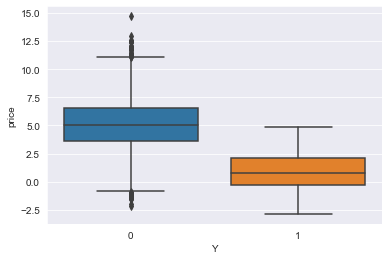

In [ ]:
def model_3():
    # dataset 2
    np.random.seed(101)
    def generate_model_3():
        g = 5
        
        # first draw X0 and X1:
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # next find piecewise-constant step function h
        if X0 < -1:
            h = -1.2
        elif -1 <= X0 < 0:
            h = -1.1
        elif 0 <= X0 < 1:
            h = -0.9
        elif 1 <= X0:
            h = -0.8

        # draw prices and noise
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = X0 + h*P + epsilon 

        return X0, X1, P, Y_star

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[]
              }

    for i in range(n):
        X0, X1, P, Y_star = generate_model_3()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))

    results = pd.DataFrame(results)

    results['dataset'] = 3
    return results
    
# visualize results
results = model_3()
sns.boxplot(data=results, x='Y', y='price')
    
results.head()

# Dataset 4

,X0,X1,price,Y,optimal_price,user_feature
0,0.891368,0.492901,7.386533,0,5.950500,1
1,1.016427,-2.838355,6.264788,0,5.379262,0
2,0.233307,1.706685,5.660522,1,7.566111,1
3,1.996105,-0.332396,7.349820,0,7.218189,0
4,-1.399865,-0.195987,6.786230,0,3.377854,0


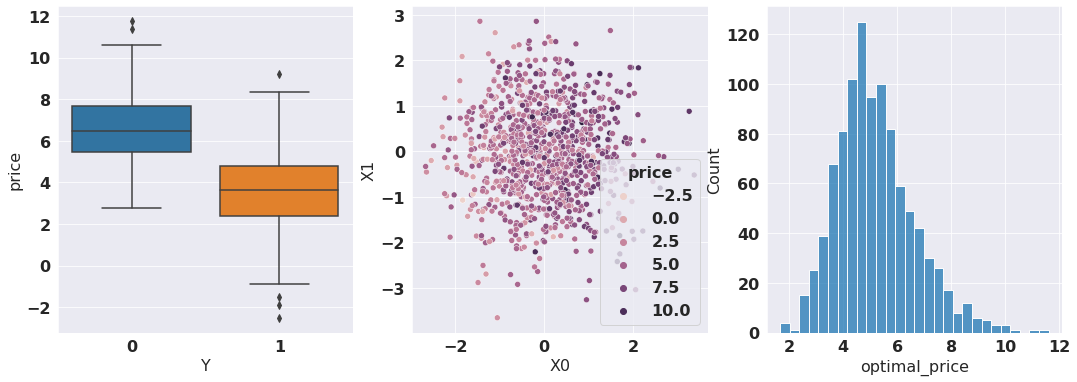

In [264]:
def model_4(n_samples): 
    # dataset 2
    # np.random.seed(101)
    def generate_model_4():
        g = 5

        # first draw X0 and X1:
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # next find piecewise-constant step function h
        # X1 influence price sensitivity, must be a 
        # consumer attribute
        h = -1.25 * int(X0 < -1) + \
          -1.1 * int(-1 <= X0 < 0) + \
          -0.9 * int(0 <= X0 < 1) + \
          -0.75 * int(1 <= X0) + \
          -0.1 * int(X1 < 0) + \
          0.1 * int(X1 >= 0)            # less sensitive to price

        # draw prices and noise
        # price depends on X0, so must be 
        # a product attribute
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = g + h*P + epsilon 

        optimal_price = -1*(g + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
              }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_4()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)
    
    return results

# visualize results
results = model_4(n_samples=1000)

results['user_feature'] = (results.X1 > 0).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])

results.head()

In [274]:
# chi2 independence test
from scipy.stats import chi2_contingency
cont_table = pd.crosstab(index=results.Y, columns=(results.X1 > 0).astype(int))

res = chi2_contingency(cont_table)
if res.pvalue < 0.01:
  print('Probability of purchase Y and user feature X1 > 0 are not independent.')
else:
  print('Probability of purchase Y and user feature X1 > 0 are independent.')


Probability of purchase Y and user feature X1 > 0 are not independent.


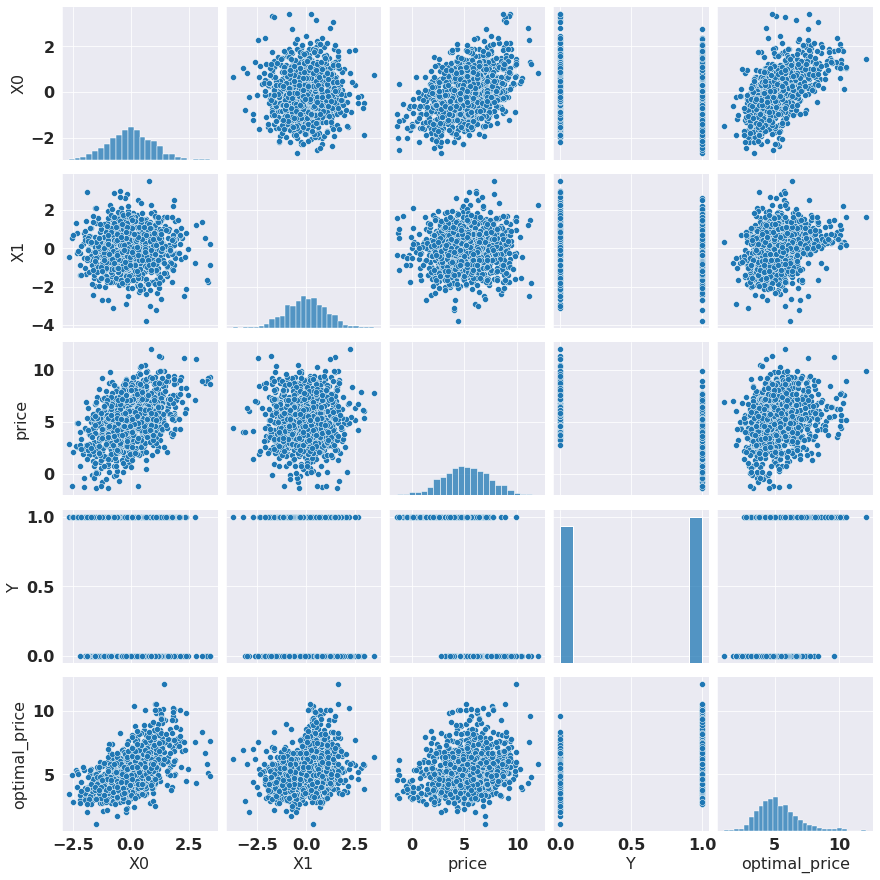

In [257]:
# make pairplot
sns.pairplot(data=results)
plt.show()

# Dataset 5
Dataset 5: linear probit model with observed confounding. The confounder is the dependence of price on covariates.

Optimal Average Revenue: -0.0010688838310354712


,X0,X1,price,Y,optimal_price
0,2.706850,0.628133,9.522789,0,3.210676
1,0.651118,-0.319318,3.954964,0,1.257083
2,-2.018168,0.740122,4.039459,0,-2.607169
3,0.188695,-0.758872,3.322221,0,1.143752
4,0.190794,1.978757,10.402729,0,0.874303


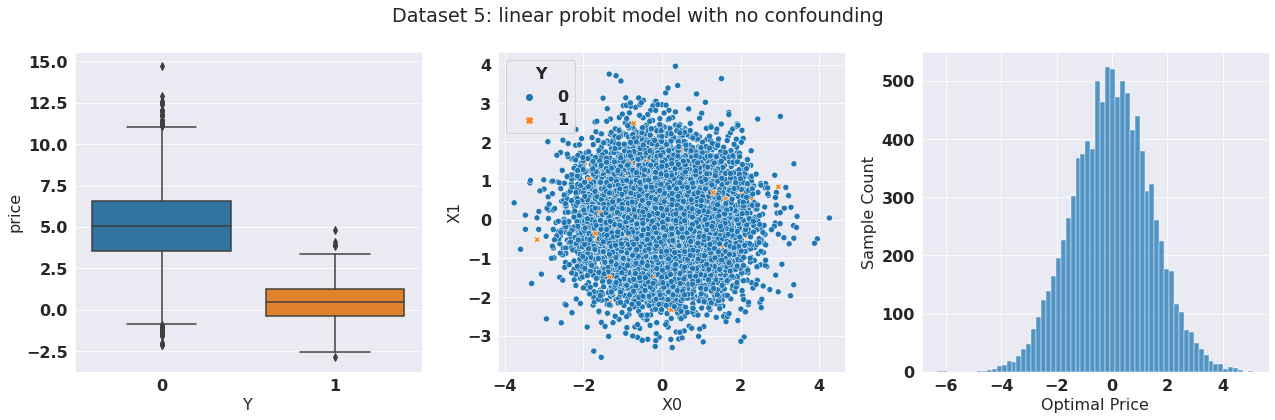

In [254]:
def model_5():
    # dataset 2: linear probit model with no confounding
    np.random.seed(101)
    def generate_model_5():
        h = -1
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        Y_star = X0 + h*P + epsilon 

        optimal_price = -1*(X0 + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
              }

    for i in range(n):
        X0, X1, P, Y_star, optimal_price = generate_model_5()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)
    # results['dataset'] = 6
    return results 

# visualize results
results = model_5()

# make figure
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='Y', style="Y", ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])
plt.suptitle("Dataset 5: linear probit model with no confounding")
 
ax[2].set_ylabel("Sample Count")
ax[2].set_xlabel("Optimal Price")
print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
    
plt.tight_layout()
# plt.savefig('figures/dataset5_sample.png')
results.head()

# Dataset 6
Dataset 6: probit model with non-linear interaction

,X0,X1,price,Y,dataset
0,2.706850,0.628133,9.522789,0,6
1,0.651118,-0.319318,3.954964,0,6
2,-2.018168,0.740122,4.039459,0,6
3,0.188695,-0.758872,3.322221,0,6
4,0.190794,1.978757,10.402729,0,6


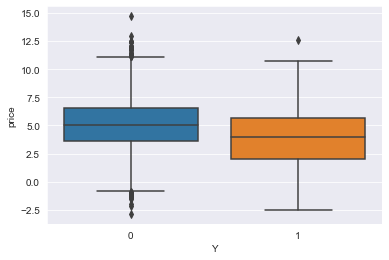

In [ ]:
def model_6():
    # dataset 2: linear probit model with no confounding
    np.random.seed(101)
    def generate_model_6():
        # first draw X0 and X1:
        I2 = np.identity(2)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # compute intercept and slope
        g = 4*np.abs(X0 + X1)
        h = -1*np.abs(X0 + X1)

        # draw price and noise
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = X0 + h*P + epsilon 

        return X0, X1, P, Y_star

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[]
              }

    for i in range(n):
        X0, X1, P, Y_star = generate_model_6()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))

    results = pd.DataFrame(results)

    # get header
    results['dataset'] = 6
    return results
    
# visualize results
results = model_6()
sns.boxplot(data=results, x='Y', y='price')

results.head()

In [ ]:
# save datasets into one csv file
# sample size
n = 10000
synthetic_data = pd.DataFrame()

# loop through models and append to empty df
models = [model_1(), model_2(), model_3(), model_4(), model_5(), model_6()]
for model in models:
    synthetic_data = pd.concat([synthetic_data, model])
    
synthetic_data.to_csv('synthetic_datasets.csv')
print(len(synthetic_data))
synthetic_data.head()

60000


,X0,X1,price,Y,dataset
0,7.706850,5.628133,5.907969,1,1
1,5.651118,4.680682,4.151923,1,1
2,2.981832,5.740122,5.528813,0,1
3,5.188695,4.241128,4.066763,1,1
4,5.190794,6.978757,7.605967,0,1


# Train lightGBM on Synthetic Data
Use default parameters with 50 boosting rounds

In [286]:
import lightgbm as lgb

def use_model(model_id, n_samples):
    if model_id == 1:
        return model_1()
    elif model_id == 2:
        return model_2()
    elif model_id == 3:
        return model_3()
    elif model_id == 4:
        return model_4(n_samples)
    elif model_id == 5:
        return model_5()
    elif model_id == 6:
        return model_6()

In [44]:
# generate dataset 1
results = use_model(5)

# get data
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train, y_train)

['X0', 'X1', 'price']


LGBMClassifier(n_estimators=50)

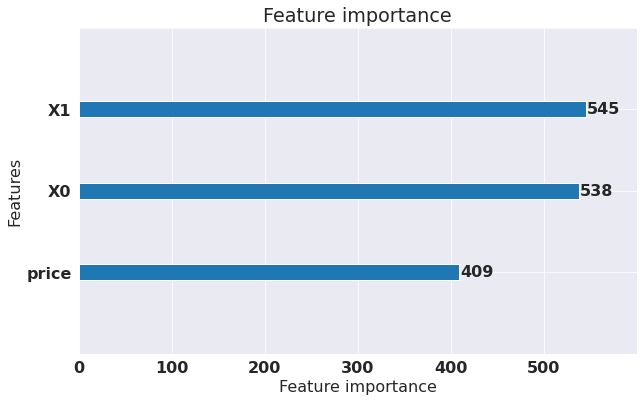

In [45]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax=ax)
plt.show()

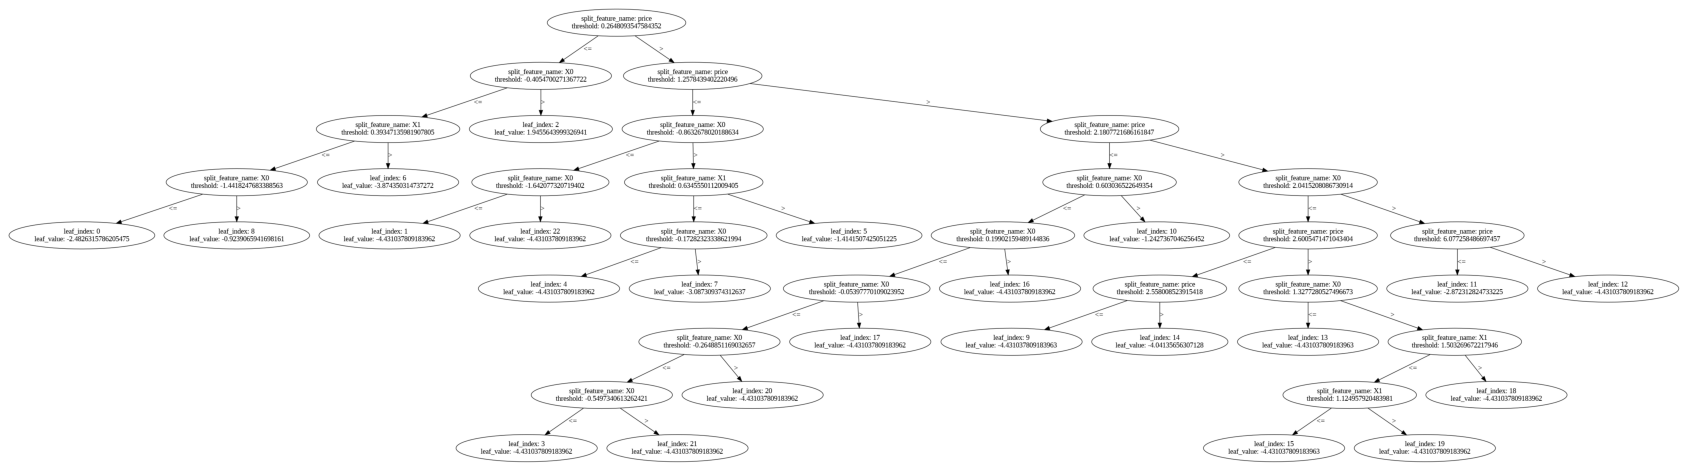

In [46]:
gig, ax = plt.subplots(figsize=(30,15))
lgb.plot_tree(model, ax=ax)

plt.show()

In [51]:
def counterfactual(X_train, X_test):
    #Biggs et al, 2020 uses 10th and 90th percentile prices in 10% increments
    low_price = X_train.price.quantile(0.10)
    high_price = X_train.price.quantile(0.90)

    print('low price:', low_price)
    print('high price:', high_price)

    prices = np.linspace(low_price, high_price, 11)
    revenue = []
    avg_purchase_prob = []
    for price in prices:
        counterfactual = X_test.copy()
        # give everyone the same global pricfe
        # no personalization
        counterfactual.price = price
        purchase_prob = model.predict_proba(counterfactual)[:, 1]
        revenue.append(np.mean(price*purchase_prob))
        avg_purchase_prob.append(np.mean(purchase_prob))

    optimal_price = prices[np.where(revenue == np.max(revenue))][0]
    
    return avg_purchase_prob, revenue, optimal_price, prices

low price: 2.1444102888303904
high price: 7.953788219340372
Optimal price 2.1444102888303904
Maximum Average Revenue: 0.225


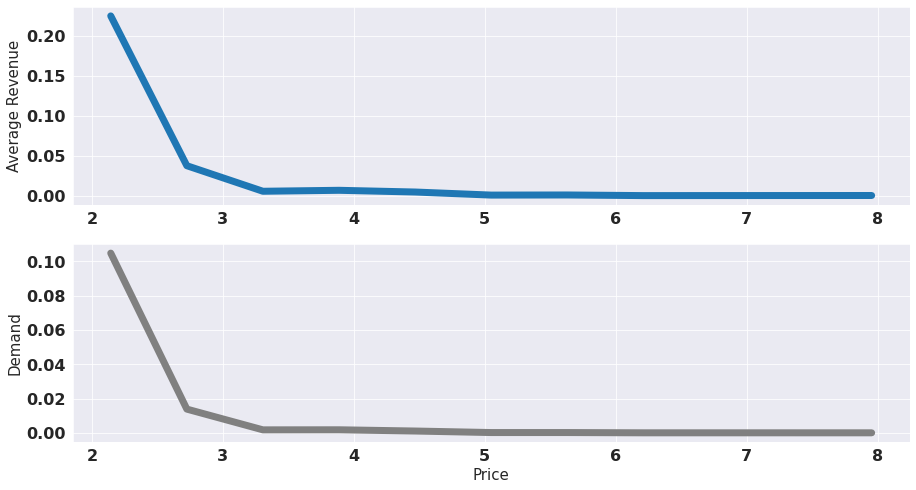

In [52]:
# estimate demand
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test)

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

# Model Distillation for Revenue Optimized Personalized Pricing

In [90]:
# generate data
results = use_model(1)

# separate features and target
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# train lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train, y_train)

print(model.score(X_train, y_train))

['X0', 'X1', 'price']
0.8402


In [8]:
def get_revenue_matrix(model, X_train):
  model.predict(X_train)

  # discretize prices
  low_price = X_train.price.quantile(0.10)
  high_price = X_train.price.quantile(0.90)

  print('low price:', low_price)
  print('high price:', high_price)

  prices = np.linspace(low_price, high_price, 11)

  # make empty response matrix
  revenue_matrix = np.empty((len(X_train), len(prices)))

  for i in range(len(prices)):
    counterfactual = X_train.copy()
    price = prices[i]
    counterfactual.price = price

    # construct reponse matrix
    revenue_matrix[:, i] = price * model.predict_proba(counterfactual)[:, 1]

  return revenue_matrix

low price: 2.1479140425432215
high price: 7.871309859196105
Optimized Revenue: 18300.844188167164
Actual Revenue: 9870.533585334873
11
3
15808.935431453967


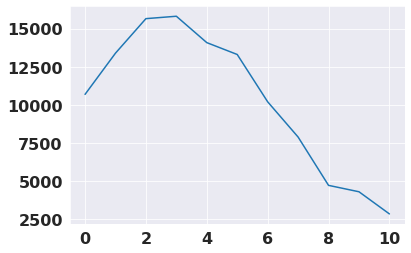

In [380]:
# get response matrix
revenue_matrix = get_revenue_matrix(model, X_train)

# calculate optimal revenue for dataset
print(
    "Optimized Revenue:",
    revenue_matrix.max(axis=1).sum()
)

print(
    "Actual Revenue:",
    (X_train['price'] * y_train).sum()
)

rev_at_price = revenue_matrix[:, :].sum(axis=0)
print(len(rev_at_price))
print(np.argmax(rev_at_price))
print(np.max(rev_at_price))
plt.plot(rev_at_price)
plt.show()

In [137]:
# create root node
root_node = dict(
    datapoints=np.arange(len(X_train)), 
    depth=0,
    left_child=None,
    right_child=None,
    revenue=None
)

print(root_node)

# intialize tree
tree = [root_node]

# set max depth stopping criteria
max_depth = 3

# intitialize list to collect leave nodes
leaf_nodes = []

def split(parent):
  """
  S: positional indices of set
  """
  # initialize right and left children
  depth = parent['depth'] + 1
  left_child = dict(datapoints=None, depth=depth)
  right_child = dict(datapoints=None, depth=depth)

  # get parent node datapoints indices
  S = parent['datapoints']

  # get corresponding data
  X = X_train.drop('price', axis=1).to_numpy()[S, :]
  n_observations, n_features = X.shape

  # search every single feature 
  # and every single observation
  # for the optimal split
  best_split_revenue = 0
  for i in range(n_observations):
    for j in range(n_features):
      # get children sets
      S1 = np.flatnonzero(X[:, j] <= X[i, j])
      S2 = np.flatnonzero(X[:, j] > X[i, j])
      # calculate total revenue
      R1 = revenue_matrix[S1, j].sum()
      R2 = revenue_matrix[S2, j].sum()
      # if set is empty associated revenue 
      # is defined as 0
      total_revenue = np.nan_to_num(R1, 0) + np.nan_to_num(R2, 0)
  
      if total_revenue > best_split_revenue:
        # update best split
        parent['split_value'] = X[i, j]
        parent['split_feature'] = j

        # update chidlren datapoints
        left_child['datapoints'] = S1
        right_child['datapoints'] = S2

        # add optimal revenue
        left_child['revenue'] = R1
        right_child['revenue'] = R2

        # update optimal greedy split revenue
        best_split_revenue = total_revenue

  # update parent children
  parent['left_child'] = left_child
  parent['right_child'] = right_child

  if depth < max_depth:
    # recursively iterate
    split(left_child)
    split(right_child)

  else:
    leaf_nodes.append(left_child)
    leaf_nodes.append(right_child)

{'datapoints': array([   0,    1,    2, ..., 2497, 2498, 2499]), 'depth': 0, 'left_child': None, 'right_child': None, 'revenue': None}


In [138]:
split(root_node)

In [139]:
# get personalized pricing revenue
sum([leaf_node['revenue'] for leaf_node in leaf_nodes])

7768.505403886294

In [447]:
S = np.arange(len(X_train))
X = X_train.drop('price', axis=1).to_numpy()[S, :]
print(X_train.shape)
print(X.shape)

i = 1
j = 1
S1 = np.flatnonzero(X[:, j] <= X[i, j])
S2 = np.flatnonzero(X[:, j] > X[i, j])

set(S1.tolist() + S2.tolist()) == set(S)

(5000, 3)
(5000, 2)


True

In [518]:
class StudentPrescriptionTree():
  def __init__(self, teacher_model, max_depth):
    self.teacher_model = teacher_model
    self.max_depth = max_depth
    self.root_node = None
    self.prices = None

  def get_revenue_matrix(self, X):
    # get descrete prices
    prices = self.prices

    # make empty response matrix
    revenue_matrix = np.empty((len(X), len(prices)))

    for i in range(len(prices)):
      counterfactual = X.copy()
      price = prices[i]
      counterfactual.price = price

      # construct reponse matrix
      revenue_matrix[:, i] = price * self.teacher_model.predict_proba(counterfactual)[:, 1]

    return revenue_matrix

  def fit(self, X_train):
    # discretize prices
    low_price = X_train.price.quantile(0.10)
    high_price = X_train.price.quantile(0.90)

    self.prices = np.linspace(low_price, high_price, 9)

    # get revenue matrix for training data
    revenue_matrix = self.get_revenue_matrix(X_train)

    # get best price index
    best_price = np.argmax(revenue_matrix.sum(axis=0))
    # get best revenue
    best_R = np.max(revenue_matrix.sum(axis=0))

    # create root node
    self.root_node = dict(
        datapoints=np.arange(len(X_train)), 
        depth=0,
        left_child=None,
        right_child=None,
        price=best_price,
        revenue=best_R
    )

    # intitialize list to collect leave nodes
    leaf_nodes = []

    def split(parent):
      """
      Split parent node into binary children
      """
      # initialize right and left children
      depth = parent['depth'] + 1
      left_child = dict(datapoints=None, depth=depth)
      right_child = dict(datapoints=None, depth=depth)

      # get parent node datapoints indices
      S = parent['datapoints']

      # get corresponding data
      X = X_train.drop('price', axis=1).to_numpy()[S, :]
      n_observations, n_features = X.shape

      # search every single feature 
      # and every single observation
      # for the optimal split
      best_split_revenue = 0
      for i in range(n_observations):
        for j in range(n_features):
          # get children sets
          S1 = S[np.flatnonzero(X[:, j] <= X[i, j])]
          S2 = S[np.flatnonzero(X[:, j] > X[i, j])]
          # now that we've split the data
          # search for the best price-combo using
          # pre-calculated revenue matrix
          # get revenue at each price point
          R1 = revenue_matrix[S1, :].sum(axis=0)
          R2 = revenue_matrix[S2, :].sum(axis=0)

          # get best price index
          best_price1 = np.argmax(R1)
          best_price2 = np.argmax(R2)
          # get best revenue
          best_R1 = np.max(R1)
          best_R2 = np.max(R2)

          # if set is empty associated revenue 
          # is defined as 0
          total_revenue = np.nan_to_num(best_R1, 0) + np.nan_to_num(best_R2, 0)
    
          if total_revenue > best_split_revenue:
            # update best split
            parent['split_value'] = X[i, j]
            parent['split_feature'] = j

            # raise exception if partitioning is 
            # improperly performed
            if set(S1.tolist() + S2.tolist()) != set(S):
              raise Exception("Disallowed Split")

            # update children datapoints
            left_child['datapoints'] = S1
            right_child['datapoints'] = S2

            # update children best greedy price indices
            left_child['price'] = best_price1
            right_child['price'] = best_price2

            # update best greedy revenue
            left_child['revenue'] = best_R1
            right_child['revenue'] = best_R2

            # update optimal greedy split revenue
            best_split_revenue = total_revenue

      # check that revenue has not decreased
      if parent['revenue'] - best_split_revenue > 0.001:
        raise Exception("Disallowed revenue decrease.",
                        total_revenue, parent['revenue'])

      # update parent children
      parent['left_child'] = left_child
      parent['right_child'] = right_child

      if depth < self.max_depth:
        # recursively iterate
        split(left_child)
        split(right_child)

      else:
        leaf_nodes.append(left_child)
        leaf_nodes.append(right_child)

    # recursivle split training data
    split(self.root_node)

  def predict(self, X_test):
    """
    Build a second tree using test data
    and first tree
    """
    # copy root node
    root_node1 = self.root_node.copy()
    root_node2 = dict(
        datapoints=np.arange(len(X_test)), 
        depth=0,
        left_child=None,
        right_child=None,
        revenue=None
    )

    # get revenue matrix for test data
    revenue_matrix = self.get_revenue_matrix(X_test)

    # intitialize list to collect leave nodes
    leaf_nodes = []

    def split(parent1, parent2):
      # get children depth
      depth = parent1['depth'] + 1
      if depth - 1 < self.max_depth:
        # get parent node datapoints indices
        S = parent2['datapoints']

        # get corresponding data
        X = X_test.drop('price', axis=1).to_numpy()[S, :]

        # split data
        j = parent1['split_feature']
        v = parent1['split_value']

        # get price assignment
        k1 = parent1['left_child']['price']
        k2 = parent1['right_child']['price']

        S1 = S[np.flatnonzero(X[:, j] <= v)]
        S2 = S[np.flatnonzero(X[:, j] > v)]

        # initialize right and left children
        left_child = dict(datapoints=None, depth=depth)
        right_child = dict(datapoints=None, depth=depth)

        # assign split datapoint
        left_child['datapoints'] = S1
        right_child['datapoints'] = S2

        # store best_price index
        left_child['price'] = k1
        right_child['price'] = k2

        # calculate total revenue
        left_child['revenue'] = revenue_matrix[S1, k1].sum()
        right_child['revenue'] = revenue_matrix[S2, k2].sum()

        # update parent children
        parent2['left_child'] = left_child
        parent2['right_child'] = right_child

        # recursively iterate
        split(parent1['left_child'], left_child)
        split(parent1['right_child'], right_child)

      else:
        leaf_nodes.append(parent2)  

    # call recursive split
    split(root_node1, root_node2)

    return leaf_nodes

  def predict_revenue(self, X_test):
    """
    Return average revenue per individual 
    from personalization
    """
    # get leave nodes
    leaf_nodes = self.predict(X_test)

    # get personalized pricing revenue
    rev = sum([leaf_node['revenue'] for leaf_node in leaf_nodes])   

    return rev / len(X_test)

  def get_optimal_revenue(self, X):
    """
    Return average revenue per individual 
    from optimal
    """
    # get revenue matrix for training data
    revenue_matrix = self.get_revenue_matrix(X)

    return revenue_matrix.max(axis=1).sum() / len(X)

In [488]:
# initialize prescription tree
tree = StudentPrescriptionTree(teacher_model=model, max_depth=4)
# fit training data
tree.fit(X_train)

In [507]:
parent = tree.root_node['left_child']['right_child']['right_child']
print("Parent Revenue:", parent['revenue'])

left_child = parent['left_child']
right_child = parent['right_child']
children_revenue = left_child['revenue'] + right_child['revenue']
print("Sum of Children Revenue:", children_revenue)

# find out what the hell is going on
S = parent['datapoints']
S1 = left_child['datapoints']
S2 = right_child['datapoints']

# check that S1 + S2 = S
print(
    set(S1.tolist() + S2.tolist()) == set(S)
)

print(len(S1) + len(S2) == len(S))

if children_revenue < parent['revenue']:
  print("Revenue has decreased.")
else:
  print("Revenue has increased.")

Parent Revenue: 774.6708081017775
Sum of Children Revenue: 783.0497155891492
True
True
Revenue has increased.


In [466]:
# get predicted revenue
test_revenue = tree.predict_revenue(X_test)
optimal_test_revenue = tree.get_optimal_revenue(X_train)
print(test_revenue)
print(optimal_test_revenue)

2.7110929832846016
3.5783138184323224


# SPT Experiment on Synthetic Data

Train lightGBM on dataset 4

In [467]:
# generate dataset 1
results = use_model(model_id=4, n_samples=10000)

# get data
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train, y_train)

['X0', 'X1', 'price']


LGBMClassifier(n_estimators=50)

In [485]:
from tqdm import tqdm

In [512]:
# try various tree depths
test_revenue = []
train_revenue = []
max_depths = [1, 2, 3, 4, 5]
for max_depth in tqdm(max_depths):  
  # initialize prescription tree
  tree = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
  # fit training data
  tree.fit(X_train)
  try:
    # get personalized tree revenue
    test_revenue.append(
        tree.predict_revenue(X_test)
      )
    train_revenue.append(
        tree.predict_revenue(X_train)
      )
  except:
    print("Invalid max depth:", max_depth)
    test_revenue.append(np.nan)
  
# get results
optimal_test_revenue = tree.get_optimal_revenue(X_test)

100%|██████████| 5/5 [00:43<00:00,  8.66s/it]


Optimal Revenue: 3.5949707071810715
Revenue, tree depth = 3: 3.5471811457254065


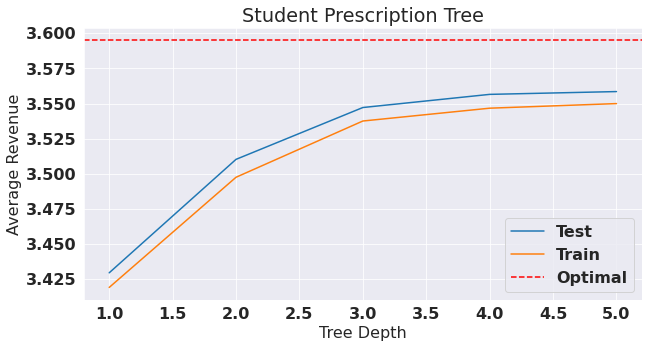

In [515]:
# make figure
fig = plt.figure(figsize=(10, 5))

# plot results
plt.plot(max_depths, test_revenue)
plt.plot(max_depths, train_revenue)
# plt.plot(max_depths, train_revenue)
plt.axhline(y=optimal_test_revenue, color='r', linestyle='--')
print(
    "Optimal Revenue:",
    optimal_test_revenue
)

print(
    "Revenue, tree depth = 3:",
    test_revenue[2]
)

plt.title("Student Prescription Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Average Revenue")
plt.legend(['Test', 'Train', 'Optimal'])

plt.show()

In [519]:
def experiment_tree_depths(model_id):
  test_revenues = []
  train_revenues = []
  optimal_test_revenues = []
  for _ in tqdm(range(10)):
    # generate dataset 1
    results = use_model(model_id=model_id, n_samples=5000)

    # get data
    covariates = [
        x for x in results.columns if x not in ['optimal_price', 'Y']
    ]
    X = results[covariates]
    y = results['Y']

    # lightGBM
    num_round = 50 
    model = lgb.LGBMClassifier(n_estimators=num_round)

    # split data in half
    from sklearn.model_selection import train_test_split 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=49, stratify=y
    )

    # fix imbalance over training set only
    model.fit(X_train, y_train)

    # try various tree depths
    test_revenue = []
    train_revenue = []
    max_depths = [1, 2, 3, 4, 5]
    for max_depth in max_depths:  
      # initialize prescription tree
      tree = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
      # fit training data
      tree.fit(X_train)
      try:
        # get personalized tree revenue
        test_revenue.append(
            tree.predict_revenue(X_test)
          )
        train_revenue.append(
          tree.predict_revenue(X_train)
        )
      except:
        print("Invalid max depth:", max_depth)
        test_revenue.append(np.nan)
      
    # get results
    optimal_test_revenue = tree.get_optimal_revenue(X_test)

    # append results
    test_revenues.append(test_revenue)
    train_revenues.append(train_revenue)
    optimal_test_revenues.append(optimal_test_revenue)

  return test_revenues, optimal_test_revenues

In [ ]:
test_revenues, optimal_test_revenues = experiment_tree_depths(model_id=4)

 70%|███████   | 7/10 [01:47<00:45, 15.30s/it]

Invalid max depth: 5



 80%|████████  | 4/5 [00:10<00:02,  2.96s/it]


In [2]:
print(
    "Actual Revenue:",
    (X_train.price * y_train).sum() / len(X_train)
)

print(tree.get_optimal_revenue(X_train))
print(tree.get_optimal_revenue(X_test))

NameError: ignored

In [1]:
sns.lineplot(data=[np.mean([x[i] for x in test_revenues]) for i in range(4)])
plt.axhline(y=np.mean(optimal_test_revenues), color='r', linestyle='--')

plt.title("Dataset 1")
plt.xlabel("Tree Depth")
plt.ylabel("Mean Revenue")
plt.show()

NameError: ignored

In [119]:
print(np.nan_to_num(np.nan, 0))
print(np.nan_to_num(3, 0))

0.0
3


# Causal Trees

In [ ]:
$ conda activate R_env

SyntaxError: invalid syntax (<ipython-input-165-ee9caf18a9ae>, line 1)

In [ ]:
%load_ext rpy2.ipython 

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()